<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/novel/Unsupervised_may15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime
import keras

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (352, 1216), antialias = True)
    img = img / 255.0
    return img'''

'def load_image(img_path):\n    img = tf.io.read_file(img_path)\n    img = tf.io.decode_jpeg(img, channels = 3)\n    img = tf.image.resize(img, size = (352, 1216), antialias = True)\n    img = img / 255.0\n    return img'

In [3]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (352 , 1216), antialias = True)
    img = img / 255.0
    return img

In [4]:
def dataset_preposses(orig_img_path='/content/drive/MyDrive/generated_dataset/trans',hazy_img_path='/content/drive/MyDrive/generated_dataset/hazy',percentage=0.1,validation_size=200,test_size=64,seed_val=200):
    train_img = []
    val_img = []
    random.seed=seed_val
    orig_img = glob.glob(orig_img_path + '/*.png')
    n = len(orig_img)
    random.shuffle(orig_img)
    red_keys=orig_img[:]                                 #redundant keys to avoid key error
    train_keys = orig_img[:int(0.9*n*percentage)]
    #print(0.9*n*percentage)
    #print(len(train_keys))
    val_keys = orig_img[-int(0.1*n*percentage):]
    #print(len(val_keys))
    split_dict = {}
    #i=0
    for key in red_keys:
      split_dict[key]='red'
      #i+=1
    #print(i)
    for key in train_keys:
      split_dict[key] = 'train'
    for key in val_keys:
      split_dict[key] = 'val'
      
    hazy_img = glob.glob(hazy_img_path + '/*.png')
    for img in hazy_img:
      
      img_name = img.split('/')[-1][:-4].split('_')[0]
      orig_path = orig_img_path + '/' + img_name+'.png'
      if (split_dict[orig_path] == 'train'):
        train_img.append([img, orig_path])
      if (split_dict[orig_path] == 'val'):
        val_img.append([img, orig_path])
      

    return train_img, val_img


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/kitti/gt'
  haze_pth='/content/drive/MyDrive/kitti/hazy'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [ ]:
train_data, val_data = dataset_preposses(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy',percentage=0.01)

In [ ]:
img = '/content/drive/MyDrive/kitti/hazy/0000000000_12_0.70802.png'
img_name = img.split('/')[-1][:-4].split('_')[0]
print(img_name)

0000000000


In [5]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [6]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img,0,training = False)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        #tf.keras.preprocessing.image.save_img(filename,display_list[i])
        plt.imsave(filename,display_list[i])
    plt.show()

In [ ]:
class T_net(tf.keras.Model):
  def __init__(self):
    super(T_net,self).__init__()
    self.conv1=Conv2D(input_shape = (352, 1216, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv2=Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv3 = Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv4 = Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv5 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    
    

  def call(self,inputs):   
    #inputs = tf.keras.Input(shape = [413,550,3])
    #pad=tf.keras.layers.ZeroPadding2D(padding=(1, 1))(inputs)
    #atm=self.get_dark_channel(inputs,15)
    #atm=self.atmlight(inputs,atm)
    conv1 = self.conv1(inputs)
    
    conv2 = self.conv2(conv1)
    concat1 = tf.concat([conv1,conv2], axis = -1)
    
    conv3 = self.conv3(concat1)
    concat2 = tf.concat([conv2,conv3], axis = -1)
    
    conv4 = self.conv4(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4], axis = -1)
    
    conv5 = self.conv5(concat3)
    K = conv5
    output = ReLU(max_value = 1.0)(K)#(tf.math.multiply(K,inputs) - K + 1.0)
    #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
    #output=tf.image.resize(output1, size = (413, 550), antialias = True)
    #model = Model(inputs = x, outputs = output)
    
    return output

  def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))


In [9]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(8, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    
    # 1st dense layer
    model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dropout(0.6))

    # 2nd dense layer
    model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dropout(0.5))

    # 3rd dense layer
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.2))


    # output layer
    model.add(keras.layers.Dense(1, activation='relu'))

    return model

In [7]:
class A_net(tf.keras.Model):
  def __init__(self):
    super(A_net,self).__init__()
    self.seq = tf.keras.Sequential()

    # 1st conv layer
    self.seq.add(tf.keras.layers.Conv2D(input_shape=(None, None, 3),filters=32,kernel_size= (3, 3), activation='relu'))
    self.seq.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    self.seq.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    self.seq.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    self.seq.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    self.seq.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    self.seq.add(keras.layers.Conv2D(8, (2, 2), activation='relu'))
    self.seq.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    self.seq.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    self.seq.add(keras.layers.Flatten())
    
    # 1st dense layer
    self.dense1=keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))
    self.drop1=keras.layers.Dropout(0.6)

    # 2nd dense layer
    self.dense2=keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))
    self.drop2=keras.layers.Dropout(0.5)

    # 3rd dense layer
    self.dense3=keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))
    self.drop3=keras.layers.Dropout(0.2)


    # output layer
    self.out=keras.layers.Dense(1, activation='relu')



  def call(self,inputs,train=True):
    x=self.seq(inputs)
    x=self.dense1(x)
    x=self.drop1(x,train)
    x=self.dense2(x)
    x=self.drop2(x,train)
    x=self.dense3(x)
    x=self.drop3(x,train)
    return self.out(x)

   #K = conv5
   #output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
   #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
   #output=tf.image.resize(output1, size = (413, 550), antialias = True)
   #model = Model(inputs = x, outputs = output)
   
   #return output

  def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

In [10]:
model1=build_model((352, 1216, 3))
model1.load_weights('/content/drive/MyDrive/nets/prelim_model/a_net/weights/0.0271')
model1.summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 350, 1214, 32)     896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 175, 607, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 175, 607, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 173, 605, 16)      4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 87, 303, 16)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 87, 303, 16)       64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 302, 8)        5

NameError: ignored

In [11]:
#batch_size = 16

class Unsuper_net(tf.keras.Model):
  def __init__(self):
    super(Unsuper_net,self).__init__()
    self.t_net=tf.keras.models.load_model('/content/drive/MyDrive/nets/prelim_model/t_net/')
    #self.a_net=build_model((352, 1216, 3))
    self.a_net=model1#tf.keras.models.load_model('/content/drive/MyDrive/nets/prelim_model/a_net/0.0271')

    for k,v in self.a_net._get_trainable_state().items():
      k.trainable = False

  def call(self,haze,gt=0,training=True):
    a1=self.a_net(haze)
    
    exp = tf.expand_dims(a1, axis=1)
    #print()
    a = tf.expand_dims(exp, axis=2)
    
    t=self.t_net(haze)
    #print(t.shape)
    #if training is True:
    #  
    #  j=gt
      #print(j.shape)
      #x=tf.keras.layers.Concatenate(axis=-1)([a,t,j])
    #  x=tf.add(tf.multiply(j,t),tf.multiply(a,(1-t)))
    #  return x
   
    #else:
   
    return  tf.add(tf.math.divide_no_nan(tf.add(haze,-(a)),t),a)   

  def model(self):
        x = Input(shape = (352, 1216, 3))
        #y = Input(shape = (352, 1216, 3))
        #return Model(inputs=[x,y], outputs=self.call(x,y))
        return Model(inputs=[x],outputs=self.call(x))
    
  def build_graph(self):
        x = Input(shape = (352, 1216, 3))
        #y = Input(shape = (352, 1216, 3))
        #return Model(inputs=[x,y], outputs=self.call(x,y))
        return Model(inputs=[x],outputs=self.call(x))


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 352, 1216, 3 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1)            26897657    input_1[0][0]                    
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (None, 1, 1)         0           sequential[0][0]                 
__________________________________________________________________________________________________
tf.expand_dims_1 (TFOpLambda)   (None, 1, 1, 1)      0           tf.expand_dims[0][0]             
______________________________________________________________________________________________

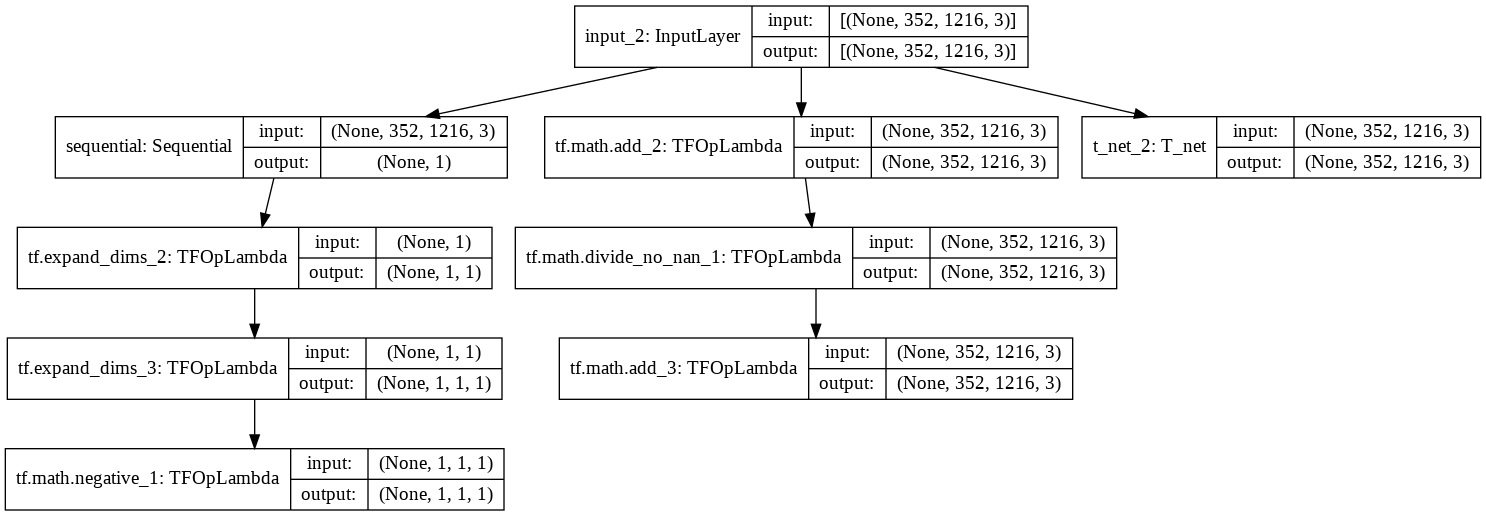

In [12]:
model=Unsuper_net()

model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

In [13]:
# Hyperparameters
epochs = 10

k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()
batch_size=1
train_data, val_data = dataset_preposses(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy',percentage=0.1)
train, val = dataloader(train_data, val_data, batch_size)
net = Unsuper_net()
optimizer = Adam(learning_rate = 1e-5)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

540


In [14]:
def train_model(epochs, train, val,net,train_loss_tracker,val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                #train_logits = net(train_batch_haze,train_batch_orig,training = True)
                #t=t_net(train_batch_haze)
                #a=a_net(train_batch_haze)
                #out=tf.add(tf.multiply(train_batch_orig,t),tf.multiply(a,(1-t)))
                train_logits=net(train_batch_haze,train_batch_orig,training=True)
                loss = mean_squared_error(train_batch_haze,train_logits)
                #loss=tf.math.reduce_mean(loss,axis=None)
                #er=tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.AUTO)
                #loss=er(train_batch_orig, train_logits)/batch_size
                #loss=tf.image.psnr(train_batch_orig, train_logits, max_val=1)
                #loss=tf.image.ssim(train_batch_orig, train_logits, max_val=1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
                #loss=custom_loss(train_batch_haze,out)
                #loss=tf.math.reduce_mean(loss)
                #print(loss)

            grads = tape.gradient(loss,net.trainable_weights)
            #grads2 = tape.gradient(loss,a_net.trainable_weights)
            #optimizer.apply_gradients(zip(grads, t_net.trainable_weights))
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze,0,False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        #net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()

In [15]:
%%time
train_model(2, train, val,net,train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 [======

KeyboardInterrupt: ignored

In [ ]:
net.save('/content/drive/MyDrive/nets/prelim_model/a_net/0.0271')
net.save_weights('/content/drive/MyDrive/nets/prelim_model/a_net/weights/0.0271')